In [1]:
import numpy as np
import pickle
import time
from matplotlib import pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

from lstm_data_prep import prep
from eval_model import epoch_time, find_lens

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
with open('HCP_movie_watching.pkl','rb') as f:
    TS = pickle.load(f)

train_loader, _ = prep(TS, pad=0.)

C:\Users\Anna\Documents\GitHub\srp-lab-notebook\hcp_data\lstm_data_prep.py:59: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_padded = paddingArr(np.array(X_arr), pad=pad)


In [3]:
class Attention(nn.Module):
    def __init__(self, n_input, n_hidden, n_out, seq_len, drop):
        self.n_input = n_input
        self.n_hidden = n_hidden
        self.n_out = n_out
        self.num_gru_layers = 1

        super().__init__()
        self.dropout = nn.Dropout(drop)
        self.gru = nn.GRU(input_size=n_input, hidden_size=n_hidden, num_layers=1, batch_first=True)
        self.fc = nn.Linear(n_hidden, n_out)

        self.fc_h = nn.Linear(n_hidden, n_hidden, bias=False)
        self.fc_out = nn.Linear(n_hidden, n_hidden, bias=False)
        self.weight = nn.Parameter(torch.FloatTensor(n_hidden))

    def forward(self, x, x_lens, h):
        batch_size = x.shape[0]

        x_packed = torch.nn.utils.rnn.pack_padded_sequence(x, x_lens, batch_first=True, enforce_sorted=False)
        
        out, hidden = self.gru(x_packed, h)
    
        out, _ = torch.nn.utils.rnn.pad_packed_sequence(out, batch_first=True, padding_value=0)

        # attention
        # (batch_size, seq_len, seq_len)
        e = torch.zeros((batch_size, out.shape[1], out.shape[1]), device=device)
        V = self.weight.repeat(batch_size, 1).unsqueeze(1)
        for i in range(out.shape[1]):
            r = torch.zeros(out.shape, device=device)
            for j in range(out.shape[1]):
                # (batch_size, seq_len, hidden_size)
                z = torch.tanh(self.fc_h(out[:, i, :]) + self.fc_out(out[:, j, :]))
                r[:, j, :] = z
            r = r.permute(0, 2, 1)
            
            a = torch.bmm(V, r).squeeze(1)
            e[:, i, :] = a
        att_weights = F.log_softmax(e, dim=-1)

        context_vector = torch.bmm(att_weights, out)
        
        y_hat = self.fc(context_vector)
        return y_hat

    def init_hidden(self, batch_size):
        return torch.zeros(self.num_gru_layers, batch_size, self.n_hidden, device=device)

In [4]:
def train(model, loss_fn, train_loader, epochs=10, learning=1e-2):
    train_loss = []
    best_loss = 1e10
    optimizer = optim.Adam(model.parameters(), lr=learning)

    model.train()
    for i in range(epochs):
        start = time.time()
        avg_loss = 0.
        for X, y in train_loader:
            loss = 0.
            curr_batch_size = X.shape[0]
            h = model.init_hidden(curr_batch_size)
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()

            X_lens = find_lens(X)

            output = model(X, X_lens, h)

            out = output.permute(0, 2, 1)
            target = y.permute(0, 2, 1)

            loss += loss_fn(out, target)
            
            loss.backward()
            optimizer.step()
            avg_loss += loss.item()

        end = time.time()
        epoch_mins, epoch_secs = epoch_time(start, end)
        if best_loss > avg_loss:
            best_loss = avg_loss
            torch.save({"attention": model.state_dict(), "att_optimizer": optimizer.state_dict()}, 'attention-model.pt')

        print("Epoch " + str(i + 1) + "/" + str(epochs))
        print("Time: " + str(epoch_mins) + " minutes " + str(epoch_secs) + " seconds")
        print("Training loss: " + str(avg_loss))
        print()
        train_loss.append(avg_loss)
    return train_loss

In [5]:
n_input = 300
n_hidden = 32
n_out = 15
seq_len = 90
drop = 0.01
EPOCHS = 20

attention = Attention(n_input, n_hidden, n_out, seq_len, drop).to(device)
loss_fn = nn.CrossEntropyLoss()

train_loss = train(attention, loss_fn, train_loader, EPOCHS)

Epoch 1/20
Time: 29 minutes 25 seconds
Training loss: 1285.0732378959656

Epoch 2/20
Time: 28 minutes 41 seconds
Training loss: 273.7205154299736

Epoch 3/20
Time: 28 minutes 22 seconds
Training loss: 184.9106590896845

Epoch 4/20
Time: 28 minutes 56 seconds
Training loss: 176.85619628429413

Epoch 5/20
Time: 28 minutes 46 seconds
Training loss: 153.6290947459638

Epoch 6/20
Time: 29 minutes 12 seconds
Training loss: 147.550477524288

Epoch 7/20
Time: 29 minutes 6 seconds
Training loss: 159.52882766351104

Epoch 8/20
Time: 28 minutes 28 seconds
Training loss: 112.32506143767387

Epoch 9/20
Time: 27 minutes 4 seconds
Training loss: 87.94720020000369

Epoch 10/20
Time: 28 minutes 46 seconds
Training loss: 108.10457845856737

Epoch 11/20
Time: 29 minutes 19 seconds
Training loss: 169.91652993371503

Epoch 12/20
Time: 29 minutes 3 seconds
Training loss: 176.26134404550797

Epoch 13/20
Time: 29 minutes 43 seconds
Training loss: 105.91512038401561

Epoch 14/20
Time: 28 minutes 43 seconds
Tra

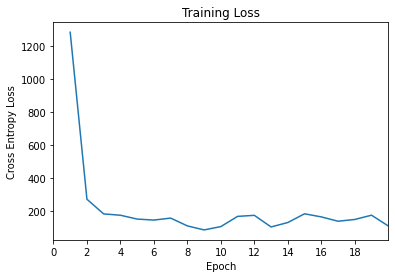

In [7]:
xAx = [i for i in range(1, EPOCHS+1)]
plt.plot(xAx, train_loss)
plt.xlabel("Epoch")
plt.ylabel("Cross Entropy Loss")
plt.xlim(0, EPOCHS)
plt.xticks([2*j for j in range(EPOCHS // 2)])
plt.title("Training Loss")
plt.show()